In [ ]:
import os
if not os.path.exists('pytorch_stylegan_encoder'):
    !git clone https://github.com/jacobhallberg/pytorch_stylegan_encoder.git
    %cd pytorch_stylegan_encoder
    !git submodule update --init --recursive
    !wget -q https://github.com/jacobhallberg/pytorch_stylegan_encoder/releases/download/v1.0/trained_models.zip
    !unzip -q trained_models.zip
    !rm trained_models.zip
    !pip install -qU torch_snippets
    !mv trained_models/stylegan_ffhq.pth InterFaceGAN/models/pretrain
else:
    %cd pytorch_stylegan_encoder

Cloning into 'pytorch_stylegan_encoder'...
remote: Enumerating objects: 358, done.
remote: Total 358 (delta 0), reused 0 (delta 0), pack-reused 358
Receiving objects: 100% (358/358), 56.88 MiB | 23.87 MiB/s, done.
Resolving deltas: 100% (185/185), done.
/content/pytorch_stylegan_encoder/pytorch_stylegan_encoder
Submodule 'InterFaceGAN' (git://github.com/ShenYujun/InterFaceGAN.git) registered for path 'InterFaceGAN'
Cloning into '/content/pytorch_stylegan_encoder/pytorch_stylegan_encoder/InterFaceGAN'...
Submodule path 'InterFaceGAN': checked out 'b707e942187f464251f855c92f7009b8cf13bf03'


In [ ]:
from torch_snippets import *

In [ ]:
from InterFaceGAN.models.stylegan_generator import StyleGANGenerator
from models.latent_optimizer import PostSynthesisProcessing

In [ ]:
synthesizer = StyleGANGenerator('stylegan_ffhq').model.synthesis
mapper = StyleGANGenerator('stylegan_ffhq').model.mapping
trunc = StyleGANGenerator('stylegan_ffhq').model.truncation

[2021-09-26 20:14:12,984][INFO] Loading pytorch model from `InterFaceGAN/models/pretrain/stylegan_ffhq.pth`.
[2021-09-26 20:14:13,262][INFO] Successfully loaded!
[2021-09-26 20:14:13,265][INFO]   `lod` of the loaded model is 0.0.
[2021-09-26 20:14:13,561][INFO] Loading pytorch model from `InterFaceGAN/models/pretrain/stylegan_ffhq.pth`.
[2021-09-26 20:14:13,818][INFO] Successfully loaded!
[2021-09-26 20:14:13,819][INFO]   `lod` of the loaded model is 0.0.
[2021-09-26 20:14:14,130][INFO] Loading pytorch model from `InterFaceGAN/models/pretrain/stylegan_ffhq.pth`.
[2021-09-26 20:14:14,378][INFO] Successfully loaded!
[2021-09-26 20:14:14,381][INFO]   `lod` of the loaded model is 0.0.


In [ ]:
post_processing = PostSynthesisProcessing()
post_process = lambda image: post_processing(image).detach().cpu().numpy().astype(np.uint8)[0]

def latent2image(latent):
    img = post_process(synthesizer(latent))
    img = img.transpose(1,2,0)
    return img

In [ ]:
rand_latents = torch.randn(1, 512).cuda()

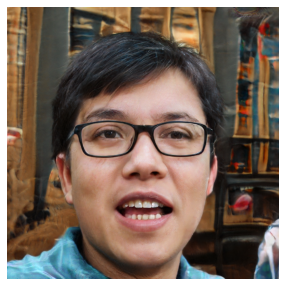

In [ ]:
show(latent2image(trunc(mapper(rand_latents))), sz=5)

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
!git clone https://github.com/Puzer/stylegan-encoder.git
!mkdir -p stylegan-encoder/raw_images
!mkdir -p stylegan-encoder/aligned-images
#!mv /content/drive/My\ Drive/data/keras_simple_recognotion/serge.jpg stylegan-encoder/raw_images
!cp /content/drive/My\ Drive/data/keras_simple_recognotion/myimg2.jpg stylegan-encoder/raw_images

In [ ]:
#!cp /content/drive/My\ Drive/data/keras_simple_recognotion/myimg2.jpg /content/pytorch_stylegan_encoder/stylegan-encoder/raw_images
!ls -l /content/pytorch_stylegan_encoder/stylegan-encoder/raw_images/

total 5092
-rw------- 1 root root 5213132 Sep 26 20:52 myimg2.jpg


In [ ]:
# change in align_images.py 'from tensorflow.keras.utils import get_file'
!python /content/pytorch_stylegan_encoder/stylegan-encoder/align_images.py /content/pytorch_stylegan_encoder/stylegan-encoder/raw_images/ /content/pytorch_stylegan_encoder/stylegan-encoder/aligned-images/
!mv /content/pytorch_stylegan_encoder/stylegan-encoder/aligned-images/* /content/serge.jpg

In [ ]:
!ls -l /content/pytorch_stylegan_encoder/stylegan-encoder/raw_images/

total 6092
-rw-rw-rw- 1 root root 6238066 Sep 26 19:36 serge.jpg


In [ ]:
#os.listdir('/content/pytorch_stylegan_encoder/stylegan-encoder/raw_images/')
#!rm -r /content/pytorch_stylegan_encoder/stylegan-encoder/raw_images/.ipynb_checkpoints

In [ ]:
from PIL import Image

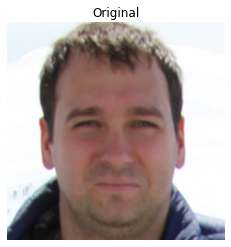

Optimizing Latents.
[2021-09-26 20:54:11,457][INFO] Loading pytorch model from `InterFaceGAN/models/pretrain/stylegan_ffhq.pth`.
[2021-09-26 20:54:11,735][INFO] Successfully loaded!
[2021-09-26 20:54:11,735][INFO]   `lod` of the loaded model is 0.0.
/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:718: UserWarning: Named tensors and all their associated APIs are an experimental feature and subject to change. Please do not use them for anything important until they are released as stable. (Triggered internally at  /pytorch/c10/core/TensorImpl.h:1156.)
  return torch.max_pool2d(input, kernel_size, stride, padding, dilation, ceil_mode)
Step: 999, Loss: 1.4726284742355347: 100% 1000/1000 [05:39<00:00,  2.95it/s]


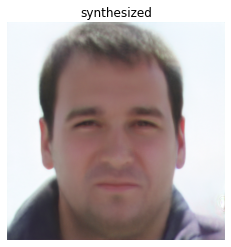

In [ ]:
img = Image.open('/content/serge.jpg')
show(np.array(img), sz=4, title='Original')

!python encode_image.py /content/serge.jpg pred_dlatents_myImage.npy --use_latent_finder true --image_to_latent_path /content/pytorch_stylegan_encoder/trained_models/image_to_latent.pt

pred_dlatents = np.load('pred_dlatents_myImage.npy')
pred_dlatent = torch.from_numpy(pred_dlatents).float().cuda()
pred_image = latent2image(pred_dlatent)
show(pred_image, sz=4, title='synthesized')

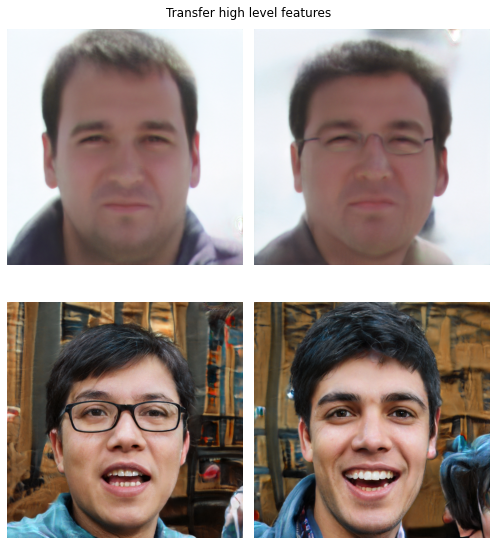

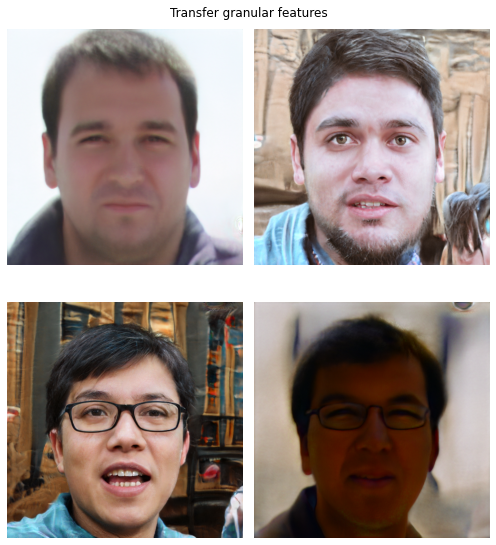

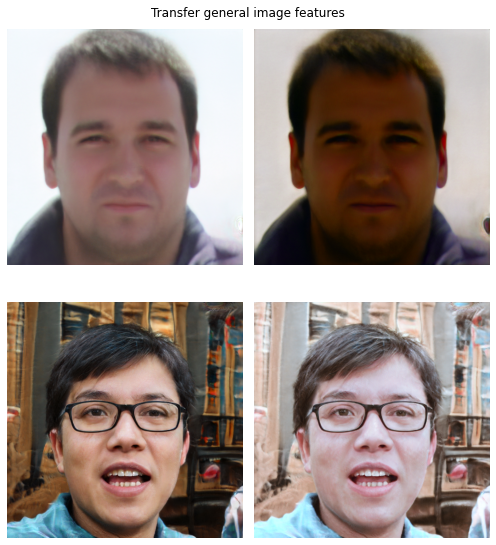

In [ ]:
idxs_to_swap = [slice(0,3), slice(4,15), slice(15,18)]
label_notations = ['Transfer high level features', 'Transfer granular features', 
                   'Transfer general image features']

my_latents = torch.Tensor(np.load('pred_dlatents_myImage.npy', allow_pickle=True))
A, B = latent2image(my_latents.cuda()), latent2image(trunc(mapper(rand_latents)))
generated_image_latents = trunc(mapper(rand_latents))

for i, indices in enumerate(idxs_to_swap):
    x = my_latents.clone()
    x[:, indices] = generated_image_latents[:, indices]
    a = latent2image(x.float().cuda())

    x = generated_image_latents.clone()
    x[:, indices] = my_latents[:, indices]
    b = latent2image(x.float().cuda())

    subplots([A, a, B, b], figsize=(7, 8), nc=2, suptitle=label_notations[i])


In [ ]:
import glob

Work directory `results_new_smile` has already existed!
Please specify another one.


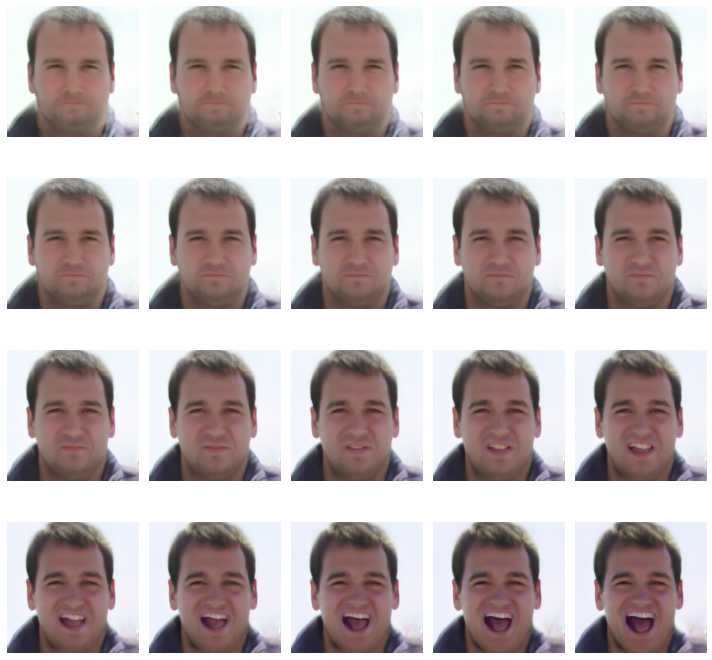

In [ ]:
!python InterFaceGAN/edit.py -m stylegan_ffhq -o results_new_smile -b InterFaceGAN/boundaries/stylegan_ffhq_smile_w_boundary.npy -i pred_dlatents_myImage.npy -s WP --steps 20
generated_faces = glob.glob('results_new_smile/*.jpg')
subplots([cv2.imread(str(im), 1)[...,::-1] for im in sorted(generated_faces)], figsize=(10, 10))

In [ ]:
!ls -l /content/pytorch_stylegan_encoder/stylegan-encoder/

total 11436
drwxr-xr-x 2 root root    4096 Sep 26 20:53 aligned-images
-rw-r--r-- 1 root root    1434 Sep 26 20:17 align_images.py
-rwxr-xr-x 1 root root     671 Sep 26 19:06 config.py
-rwxr-xr-x 1 root root   30421 Sep 26 19:06 dataset_tool.py
drwxr-xr-x 4 root root    4096 Sep 26 19:06 dnnlib
-rw-r--r-- 1 root root    3682 Sep 26 19:06 encode_images.py
drwxr-xr-x 2 root root    4096 Sep 26 19:06 encoder
drwxr-xr-x 5 root root    4096 Sep 26 20:05 ffhq_dataset
-rwxr-xr-x 1 root root    9563 Sep 26 19:06 generate_figures.py
-rw-r--r-- 1 root root 8010901 Sep 26 19:06 Learn_direction_in_latent_space.ipynb
-rwxr-xr-x 1 root root   19406 Sep 26 19:06 LICENSE.txt
drwxr-xr-x 2 root root    4096 Sep 26 19:06 metrics
-rw-r--r-- 1 root root 2727544 Sep 26 19:06 Play_with_latent_directions.ipynb
-rwxr-xr-x 1 root root    1781 Sep 26 19:06 pretrained_example.py
drwxr-xr-x 2 root root    4096 Sep 26 20:53 raw_images
-rwxr-xr-x 1 root root   22039 Sep 26 19:06 README.md
-rw-r--r-- 1 root root     